<a href="https://colab.research.google.com/github/peterbabulik/QuantumWalker/blob/main/GHZtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit qiskit-ibm-runtime qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.9/359.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0

Successfully imported Qiskit Runtime modules.
Attempting to initialize IBM QiskitRuntimeService directly with provided token for instance: ibm-q/open/main


<ipython-input-2-1eac299adfc5>:36: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


IBM QiskitRuntimeService initialized directly with provided token.

Available backends from QiskitRuntimeService (will attempt to filter for simulators first):

Attempting to get a 'least_busy' SIMULATOR from QiskitRuntimeService (min 3 qubits)...
Error using service.least_busy(simulator=True): 'No backend matches the criteria.'

Cloud simulator not found or selected. Attempting to get QPU backend: ibm_brisbane...
Selected QPU backend for Qiskit Runtime: ibm_brisbane (Qubits: 127, Status: <qiskit_ibm_runtime.models.backend_status.BackendStatus object at 0x7f812bfd1790>)

Building a simple 3-qubit test circuit (e.g., GHZ)...

--- Generated Test Circuit ---
        ┌───┐           ░ ┌─┐      
   q_0: ┤ H ├──■────■───░─┤M├──────
        └───┘┌─┴─┐  │   ░ └╥┘┌─┐   
   q_1: ─────┤ X ├──┼───░──╫─┤M├───
             └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ──────────┤ X ├─░──╫──╫─┤M├
                  └───┘ ░  ║  ║ └╥┘
meas: 3/═══════════════════╩══╩══╩═
                           0  1  2 

--- Transpi

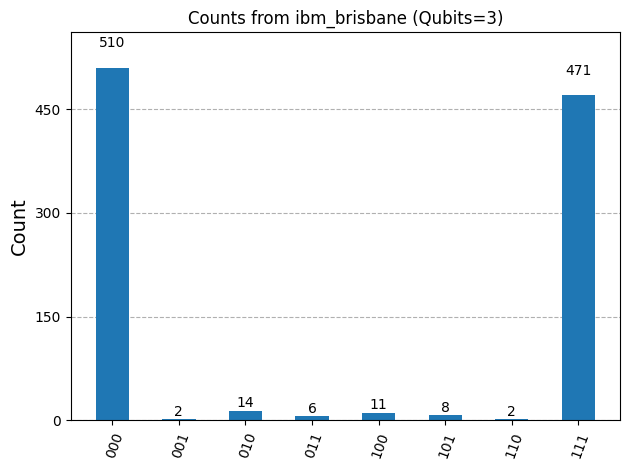


EXPERIMENT CONCLUDED. Please remember to invalidate the API token '99dd752798...' (used directly in this script) on the IBM Quantum website: https://quantum.ibm.com/account


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import time
import os

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

# Modern IBM Quantum access
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Session
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    from qiskit_ibm_runtime.ibm_backend import IBMBackend as IBMRuntimeBackend
    qiskit_runtime_available = True
    print("Successfully imported Qiskit Runtime modules.")
except ImportError:
    print("CRITICAL WARNING: qiskit_ibm_runtime could not be imported. IBM Quantum execution will fail.")
    QiskitRuntimeService = None; Sampler = None; Session = None; generate_preset_pass_manager = None
    IBMRuntimeBackend = None
    qiskit_runtime_available = False

# --- Parameters for this test ---
NUM_QUBITS_FOR_TEST = 3

# --- IBM Quantum API Token and Instance Details ---
IBM_QUANTUM_TOKEN_DIRECT = 'API KEY HERE'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'
IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'

service = None
if qiskit_runtime_available:
    try:
        print(f"Attempting to initialize IBM QiskitRuntimeService directly with provided token for instance: {IBM_QUANTUM_INSTANCE_DIRECT}")
        service = QiskitRuntimeService(
            channel=IBM_QUANTUM_CHANNEL_DIRECT,
            instance=IBM_QUANTUM_INSTANCE_DIRECT,
            token=IBM_QUANTUM_TOKEN_DIRECT
        )
        print("IBM QiskitRuntimeService initialized directly with provided token.")
    except Exception as e:
        print(f"ERROR: Could not initialize QiskitRuntimeService directly with token: {e}")
        service = None
else:
    print("qiskit_ibm_runtime package is not available. Cannot use IBM Quantum Primitives.")

# --- Select Backend ---
backend = None
backend_name_to_print = "AerSimulator (local)"
backend_target_name = 'ibm_brisbane'

if service:
    print("\nAvailable backends from QiskitRuntimeService (will attempt to filter for simulators first):")
    # ... (listing backends can be kept or commented out for brevity) ...
    try:
        print(f"\nAttempting to get a 'least_busy' SIMULATOR from QiskitRuntimeService (min {NUM_QUBITS_FOR_TEST} qubits)...")
        runtime_simulator_backend = service.least_busy(min_num_qubits=NUM_QUBITS_FOR_TEST, simulator=True, operational=None)
        if runtime_simulator_backend:
            backend = runtime_simulator_backend
            backend_name_to_print = backend.name
            print(f"Selected CLOUD SIMULATOR for Qiskit Runtime: {backend.name} (Qubits: {backend.num_qubits})")
        else:
            print("service.least_busy(simulator=True) did not return a backend.")
    except Exception as e_least_busy_sim:
        print(f"Error using service.least_busy(simulator=True): {e_least_busy_sim}")

    if backend is None:
        print(f"\nCloud simulator not found or selected. Attempting to get QPU backend: {backend_target_name}...")
        try:
            qpu_backend_obj = service.backend(backend_target_name)
            if qpu_backend_obj:
                backend = qpu_backend_obj
                backend_name_to_print = backend.name
                print(f"Selected QPU backend for Qiskit Runtime: {backend.name} (Qubits: {backend.num_qubits}, Status: {backend.status()})") # Call status()
                if hasattr(backend, 'status') and callable(backend.status) and backend.status().status_msg != 'active':
                    print(f"WARNING: QPU {backend.name} status is {backend.status().status_msg}. May not be ideal for running jobs.")
            else:
                print(f"QPU backend {backend_target_name} not found or not available via service.")
                backend = None
        except Exception as e_qpu:
            print(f"Could not get QPU backend '{backend_target_name}': {e_qpu}")

if backend is None:
    print("\nNo cloud backend (simulator or QPU) successfully obtained. Falling back to local AerSimulator.")
    backend = AerSimulator()
    backend_name_to_print = "AerSimulator (local)"

# --- Define Test Circuit ---
print(f"\nBuilding a simple {NUM_QUBITS_FOR_TEST}-qubit test circuit (e.g., GHZ)...")
qc_test = QuantumCircuit(NUM_QUBITS_FOR_TEST)
q_test = qc_test.qubits
qc_test.h(q_test[0])
if NUM_QUBITS_FOR_TEST >= 2: qc_test.cx(q_test[0], q_test[1])
if NUM_QUBITS_FOR_TEST >= 3: qc_test.cx(q_test[0], q_test[2])
qc_test.measure_all(inplace=True)
print("\n--- Generated Test Circuit ---")
try: print(qc_test.draw(output='text'))
except Exception as e_draw: print(f"Could not draw circuit: {e_draw}")

# --- Transpile and Run ---
print(f"\n--- Transpiling and Running on {backend_name_to_print} ---")
counts = {}
try:
    shots = 1024
    isa_circuit = qc_test
    is_runtime_target = False
    if qiskit_runtime_available and service and backend:
        if IBMRuntimeBackend and isinstance(backend, IBMRuntimeBackend):
            is_runtime_target = True
        elif hasattr(backend, 'provider') and "runtime" in str(type(backend.provider)).lower() and backend.name != "aer_simulator":
             is_runtime_target = True

    if is_runtime_target and generate_preset_pass_manager is not None:
        print("Transpiling for Qiskit Runtime backend using preset pass manager...")
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuit = pm.run(qc_test)
        print(f"Test circuit depth original: {qc_test.depth()}, transpiled (ISA): {isa_circuit.depth()}")
    elif isinstance(backend, AerSimulator):
        print(f"Basic transpilation for {backend_name_to_print}...")
        isa_circuit = transpile(qc_test, backend=backend, optimization_level=1)
        print(f"Test circuit depth original: {qc_test.depth()}, transpiled: {isa_circuit.depth()}")
    else:
        print(f"Using original circuit for {backend_name_to_print} (depth: {qc_test.depth()}).")

    if is_runtime_target and Sampler is not None and Session is not None :
        print(f"Using QiskitRuntimeService SamplerV2 for backend: {backend.name}")
        # CORRECTED Session and Sampler instantiation
        with Session(backend=backend) as session:
            sampler = Sampler() # Instantiate Sampler without session here
            pub = (isa_circuit,)
            job = sampler.run([pub], shots=shots) # Session is implicitly used by Sampler here
            print(f"Job ID: {job.job_id()} submitted to Qiskit Runtime.")
            print("Waiting for results (this might take a while for QPUs)...")
            result = job.result()

            print("Processing SamplerV2 results...")
            if result and len(result) > 0:
                pub_result = result[0]
                if hasattr(pub_result.data, 'meas'):
                    counts = pub_result.data.meas.get_counts()
                    print("Counts obtained from 'meas' field (measure_all was used).")
                else:
                    print("WARNING: No 'meas' field in SamplerV2 data.")
                    print("Data fields available:", pub_result.data.__dict__.keys() if hasattr(pub_result, 'data') and hasattr(pub_result.data, '__dict__') else "No data object or __dict__")
                    counts = {}
            else:
                print("ERROR: Job result is None or empty from SamplerV2.")
                counts = {}
    elif isinstance(backend, AerSimulator):
        print(f"Using legacy backend.run() for {backend_name_to_print}")
        job = backend.run(isa_circuit, shots=shots)
        result = job.result()
        counts = result.get_counts(0)
    else:
        print(f"ERROR: No suitable execution path found. Backend: {backend.name if backend else 'None'}")
        counts = {}

    print("\n--- Results ---")
    print("Counts:", counts)

    if counts:
        from qiskit.visualization import plot_histogram
        fig = plot_histogram(counts, title=f"Counts from {backend_name_to_print} (Qubits={NUM_QUBITS_FOR_TEST})")
        try: display(fig)
        except NameError: plt.show()
    else: print("No counts data to plot.")

except Exception as main_e:
    print(f"An error occurred in the main script: {main_e}")
    import traceback
    traceback.print_exc()
finally:
    print(f"\nEXPERIMENT CONCLUDED. Please remember to invalidate the API token "
          f"'{IBM_QUANTUM_TOKEN_DIRECT[:10]}...' (used directly in this script) "
          f"on the IBM Quantum website: https://quantum.ibm.com/account")